(GLM-simpsons-paradox)=
# Simpson's paradox and mixed models

:::{post} March, 2022
:tags: regression, hierarchical model, linear model, multi level model, posterior predictive, Simpson's paradox
:category: beginner
:author: Benjamin T. Vincent
:::

This notebook covers:
- [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) and its resolution through mixed or hierarchical models. This is a situation where there might be a negative relationship between two variables within a group, but when data from multiple groups are combined, that relationship may disappear or even reverse sign. The gif below (from the [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) Wikipedia page) demonstrates this very nicely.
- How to build linear regression models, starting with linear regression, moving up to hierarchical linear regression. Simpon's paradox is a nice motivation for why we might want to do this - but of course we should aim to build models which incorporate as much as our knowledge about the structure of the data (e.g. it's nested nature) as possible.
- Use of `pm.Data` containers to facilitate posterior prediction at different $x$ values with the same model.
- Providing array dimensions (see `coords`) to models to help with shape problems. This involves the use of [xarray](http://xarray.pydata.org/) and is quite helpful in multi-level / hierarchical models.
- Differences between posteriors and posterior predictive distributions.
- How to visualise models in data space and parameter space, using a mixture of [ArviZ](https://arviz-devs.github.io/arviz/) and [matplotlib](https://matplotlib.org/).

![](https://upload.wikimedia.org/wikipedia/commons/f/fb/Simpsons_paradox_-_animation.gif)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Generate data

This data generation was influenced by this [stackexchange](https://stats.stackexchange.com/questions/479201/understanding-simpsons-paradox-with-random-effects) question.

In [3]:
def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list

In [4]:
data, group_list = generate()

To follow along, it is useful to clearly understand the form of the data. This is [long form](https://en.wikipedia.org/wiki/Wide_and_narrow_data) data (also known as narrow data) in that each row represents one observation. We have a `group` column which has the group label, and an accompanying numerical `group_idx` column. This is very useful when it comes to modelling as we can use it as an index to look up group-level parameter estimates. Finally, we have our core observations of the predictor variable `x` and the outcome `y`.

In [5]:
display(data)

group  group_idx         x         y
0    one          0 -0.294574 -2.338519
1    one          0 -4.686497 -1.448057
2    one          0 -2.262201 -1.393728
3    one          0 -4.873809 -0.265403
4    one          0 -2.863929 -0.774251
..   ...        ...       ...       ...
95  five          4  3.981413  0.467970
96  five          4  1.889102  0.553290
97  five          4  2.561267  2.590966
98  five          4  0.147378  2.050944
99  five          4  2.738073  0.517918

[100 rows x 4 columns]

And we can visualise this as below.

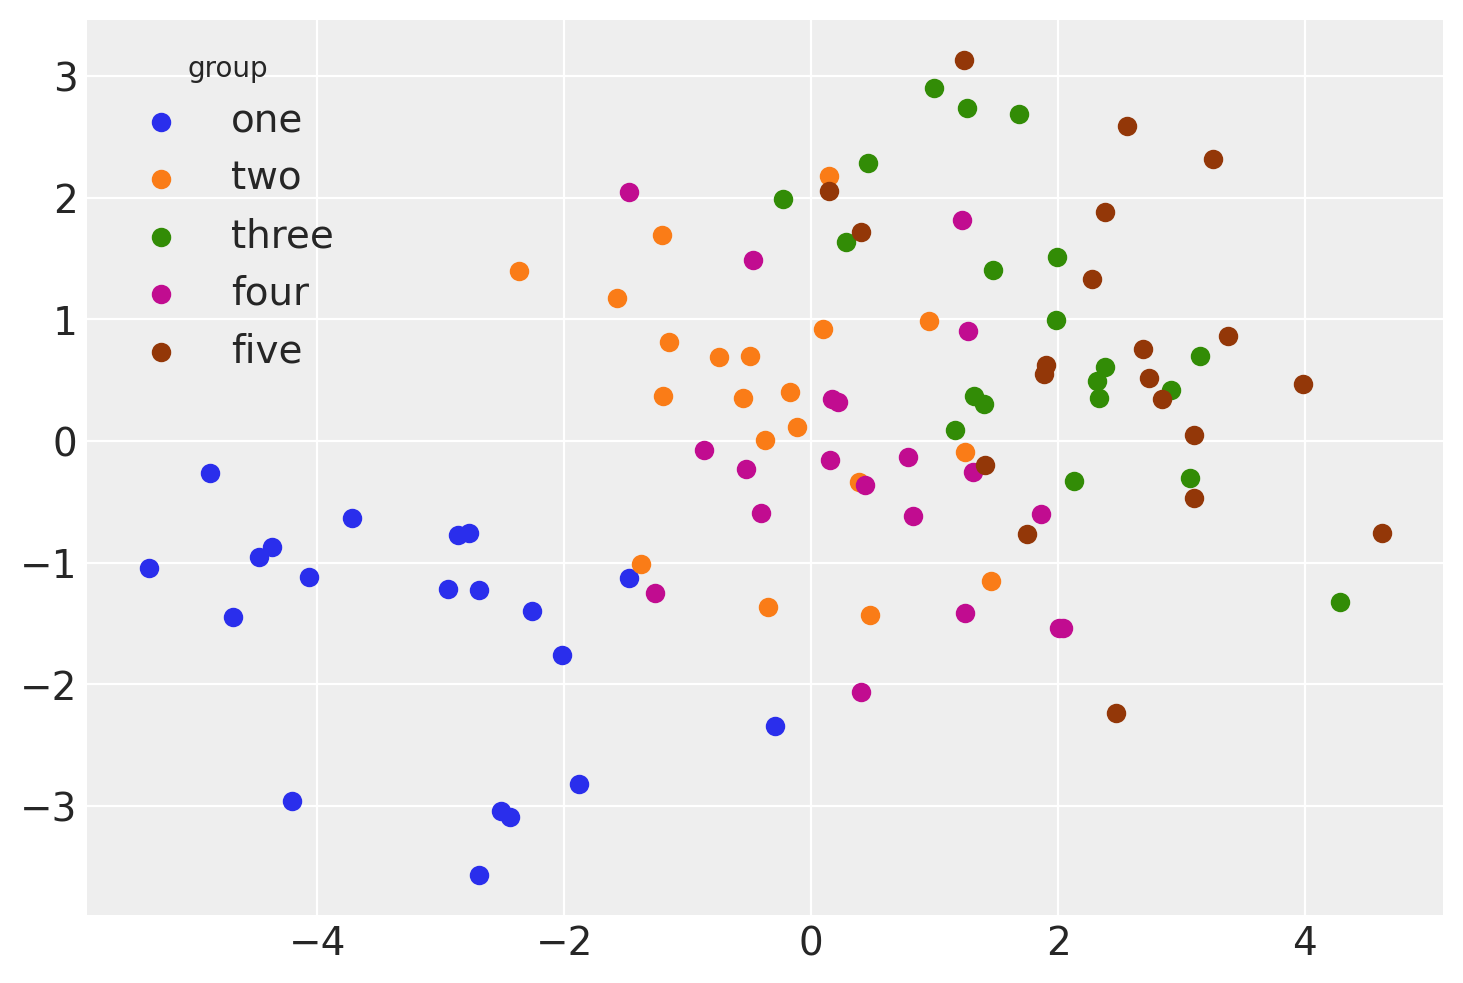

In [6]:
for i, group in enumerate(group_list):
    plt.scatter(
        data.query(f"group_idx=={i}").x,
        data.query(f"group_idx=={i}").y,
        color=f"C{i}",
        label=f"{group}",
    )
plt.legend(title="group");

The rest of the notebook will cover different ways that we can analyse this data using linear models.

## Model 1: Basic linear regression

First we examine the simplest model - plain linear regression which pools all the data and has no knowledge of the group/multi-level structure of the data.

### Build model

In [7]:
with pm.Model() as linear_regression:
    sigma = pm.HalfCauchy("sigma", beta=2)
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    x = pm.MutableData("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x)
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

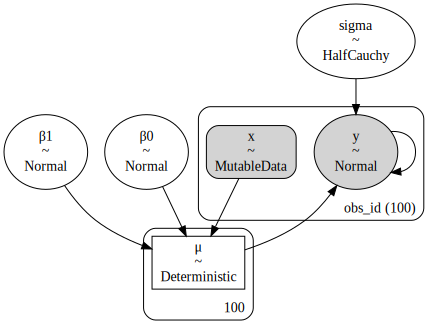

In [8]:
pm.model_to_graphviz(linear_regression)

### Do inference

In [9]:
with linear_regression:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, β0, β1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


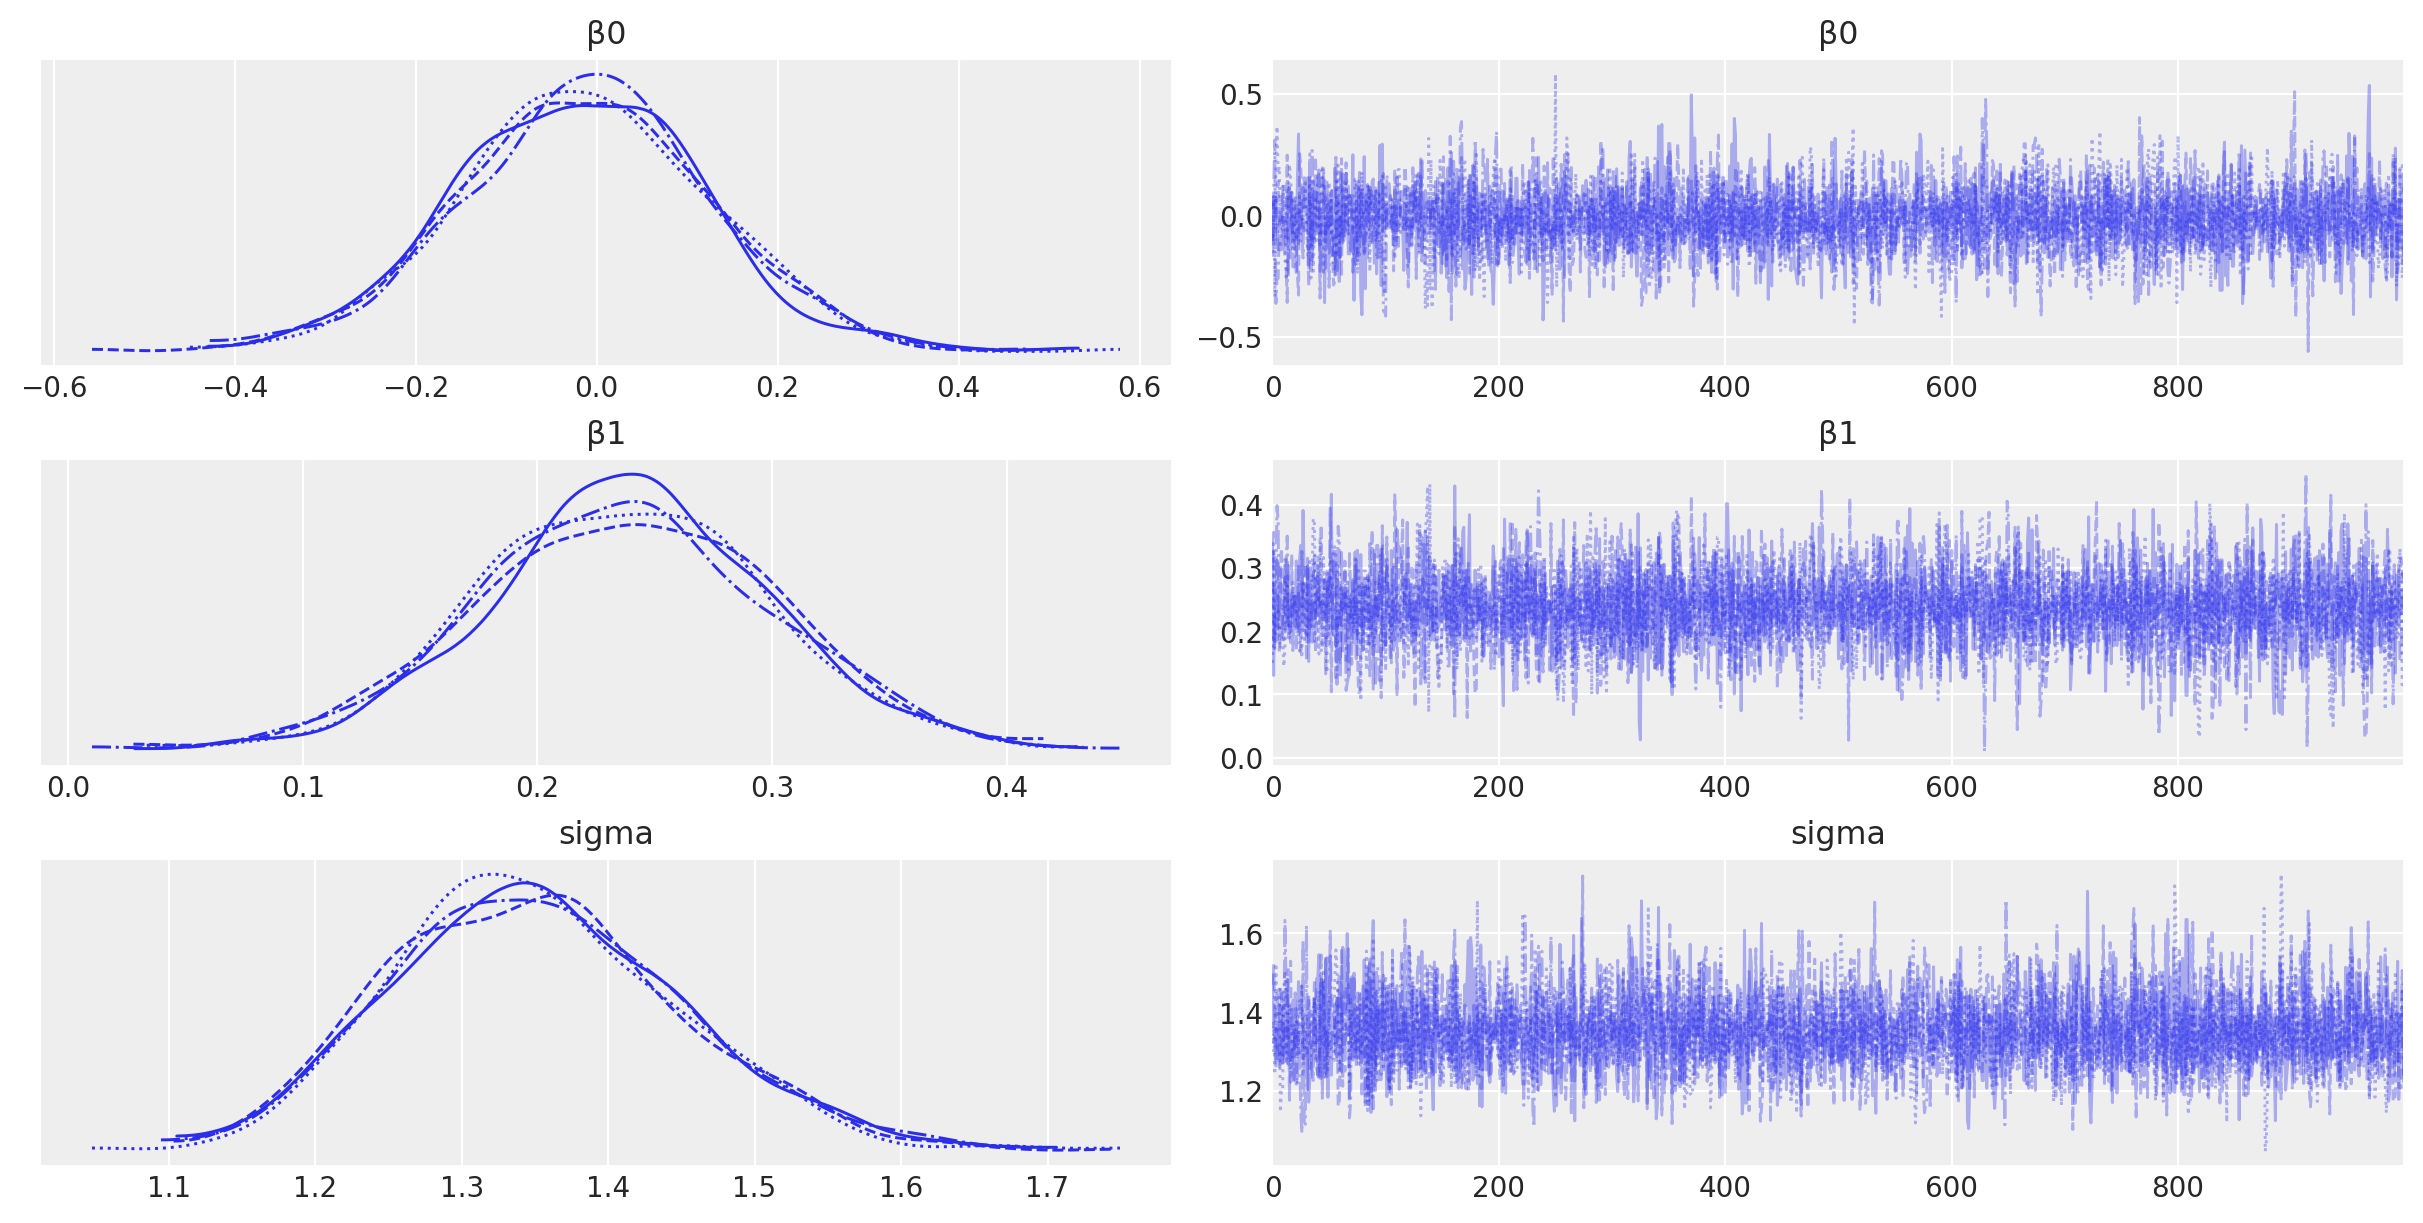

In [10]:
az.plot_trace(idata, filter_vars="regex", var_names=["~μ"]);

### Visualisation

In [11]:
# posterior prediction for these x values
xi = np.linspace(data.x.min(), data.x.max(), 20)

# do posterior predictive inference
with linear_regression:
    pm.set_data({"x": xi})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["y", "μ"]))

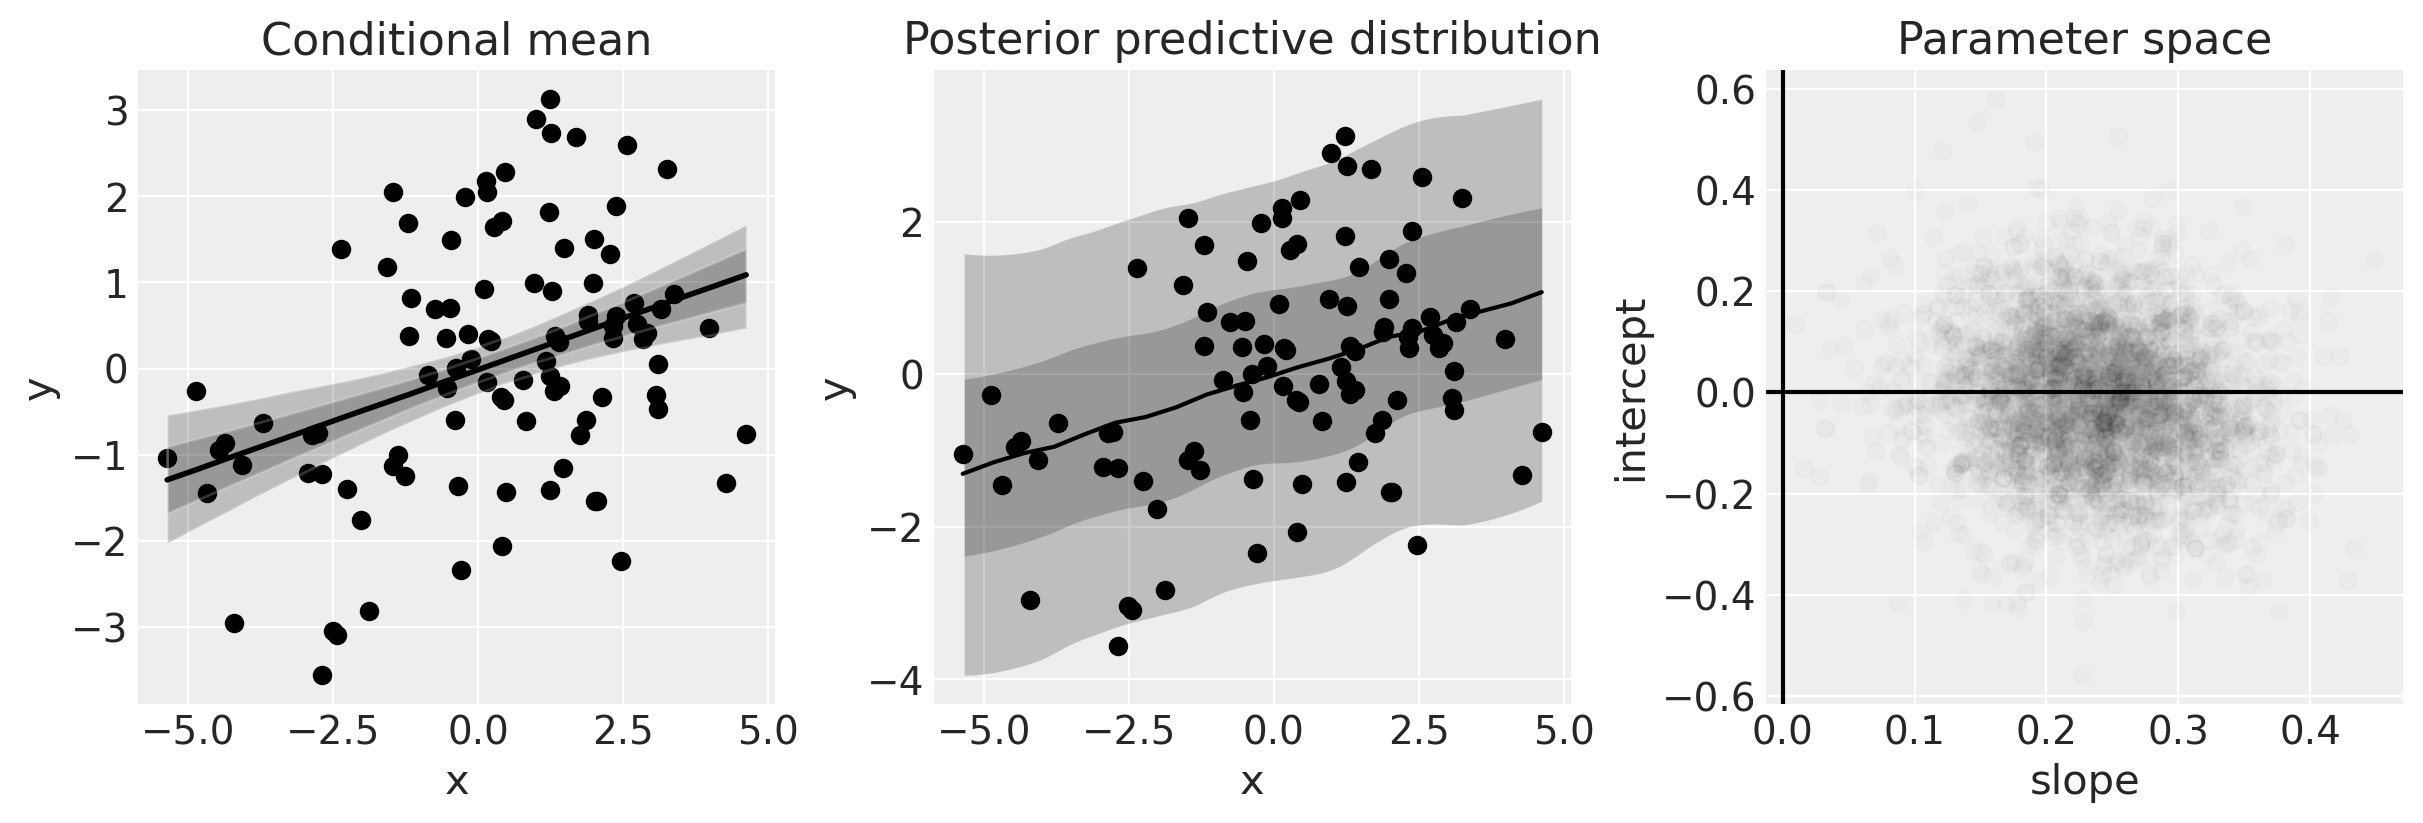

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# conditional mean plot ---------------------------------------------
# data
ax[0].scatter(data.x, data.y, color="k")
# conditional mean credible intervals
post = idata.posterior.stack(sample=("chain", "draw"))
xi = xr.DataArray(np.linspace(np.min(data.x), np.max(data.x), 20), dims=["x_plot"])
y = post.β0 + post.β1 * xi
region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
ax[0].fill_between(
    xi, region.sel(quantile=0.025), region.sel(quantile=0.975), alpha=0.2, color="k", edgecolor="w"
)
ax[0].fill_between(
    xi, region.sel(quantile=0.15), region.sel(quantile=0.85), alpha=0.2, color="k", edgecolor="w"
)
# conditional mean
ax[0].plot(xi, region.sel(quantile=0.5), "k", linewidth=2)
# formatting
ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

# posterior prediction ----------------------------------------------
# data
ax[1].scatter(data.x, data.y, color="k")
# posterior mean and HDI's

ax[1].plot(xi, idata.posterior_predictive.y.mean(["chain", "draw"]), "k")

az.plot_hdi(
    xi,
    idata.posterior_predictive.y,
    hdi_prob=0.6,
    color="k",
    fill_kwargs={"alpha": 0.2, "linewidth": 0},
    ax=ax[1],
)
az.plot_hdi(
    xi,
    idata.posterior_predictive.y,
    hdi_prob=0.95,
    color="k",
    fill_kwargs={"alpha": 0.2, "linewidth": 0},
    ax=ax[1],
)
# formatting
ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

# parameter space ---------------------------------------------------
ax[2].scatter(
    idata.posterior.β1.stack(sample=("chain", "draw")),
    idata.posterior.β0.stack(sample=("chain", "draw")),
    color="k",
    alpha=0.01,
    rasterized=True,
)

# formatting
ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
ax[2].axhline(y=0, c="k")
ax[2].axvline(x=0, c="k");

The plot on the left shows the data and the posterior of the **conditional mean**. For a given $x$, we get a posterior distribution of the model (i.e. of $\mu$).

The plot in the middle shows the **posterior predictive distribution**, which gives a statement about the data we expect to see. Intuitively, this can be understood as not only incorporating what we know of the model (left plot) but also what we know about the distribution of error.

The plot on the right shows out posterior beliefs in **parameter space**.

One of the clear things about this analysis is that we have credible evidence that $x$ and $y$ are _positively_ correlated. We can see this from the posterior over the slope (see right hand panel in the figure above).

## Model 2: Independent slopes and intercepts model

We will use the same data in this analysis, but this time we will use our knowledge that data come from groups. More specifically we will essentially fit independent regressions to data within each group.

In [13]:
coords = {"group": group_list}

with pm.Model(coords=coords) as ind_slope_intercept:
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=2, dims="group")
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

By plotting the DAG for this model it is clear to see that we now have individual intercept, slope, and variance parameters for each of the groups.

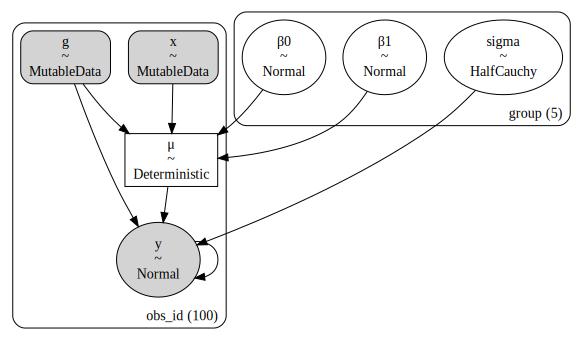

In [14]:
pm.model_to_graphviz(ind_slope_intercept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, β0, β1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


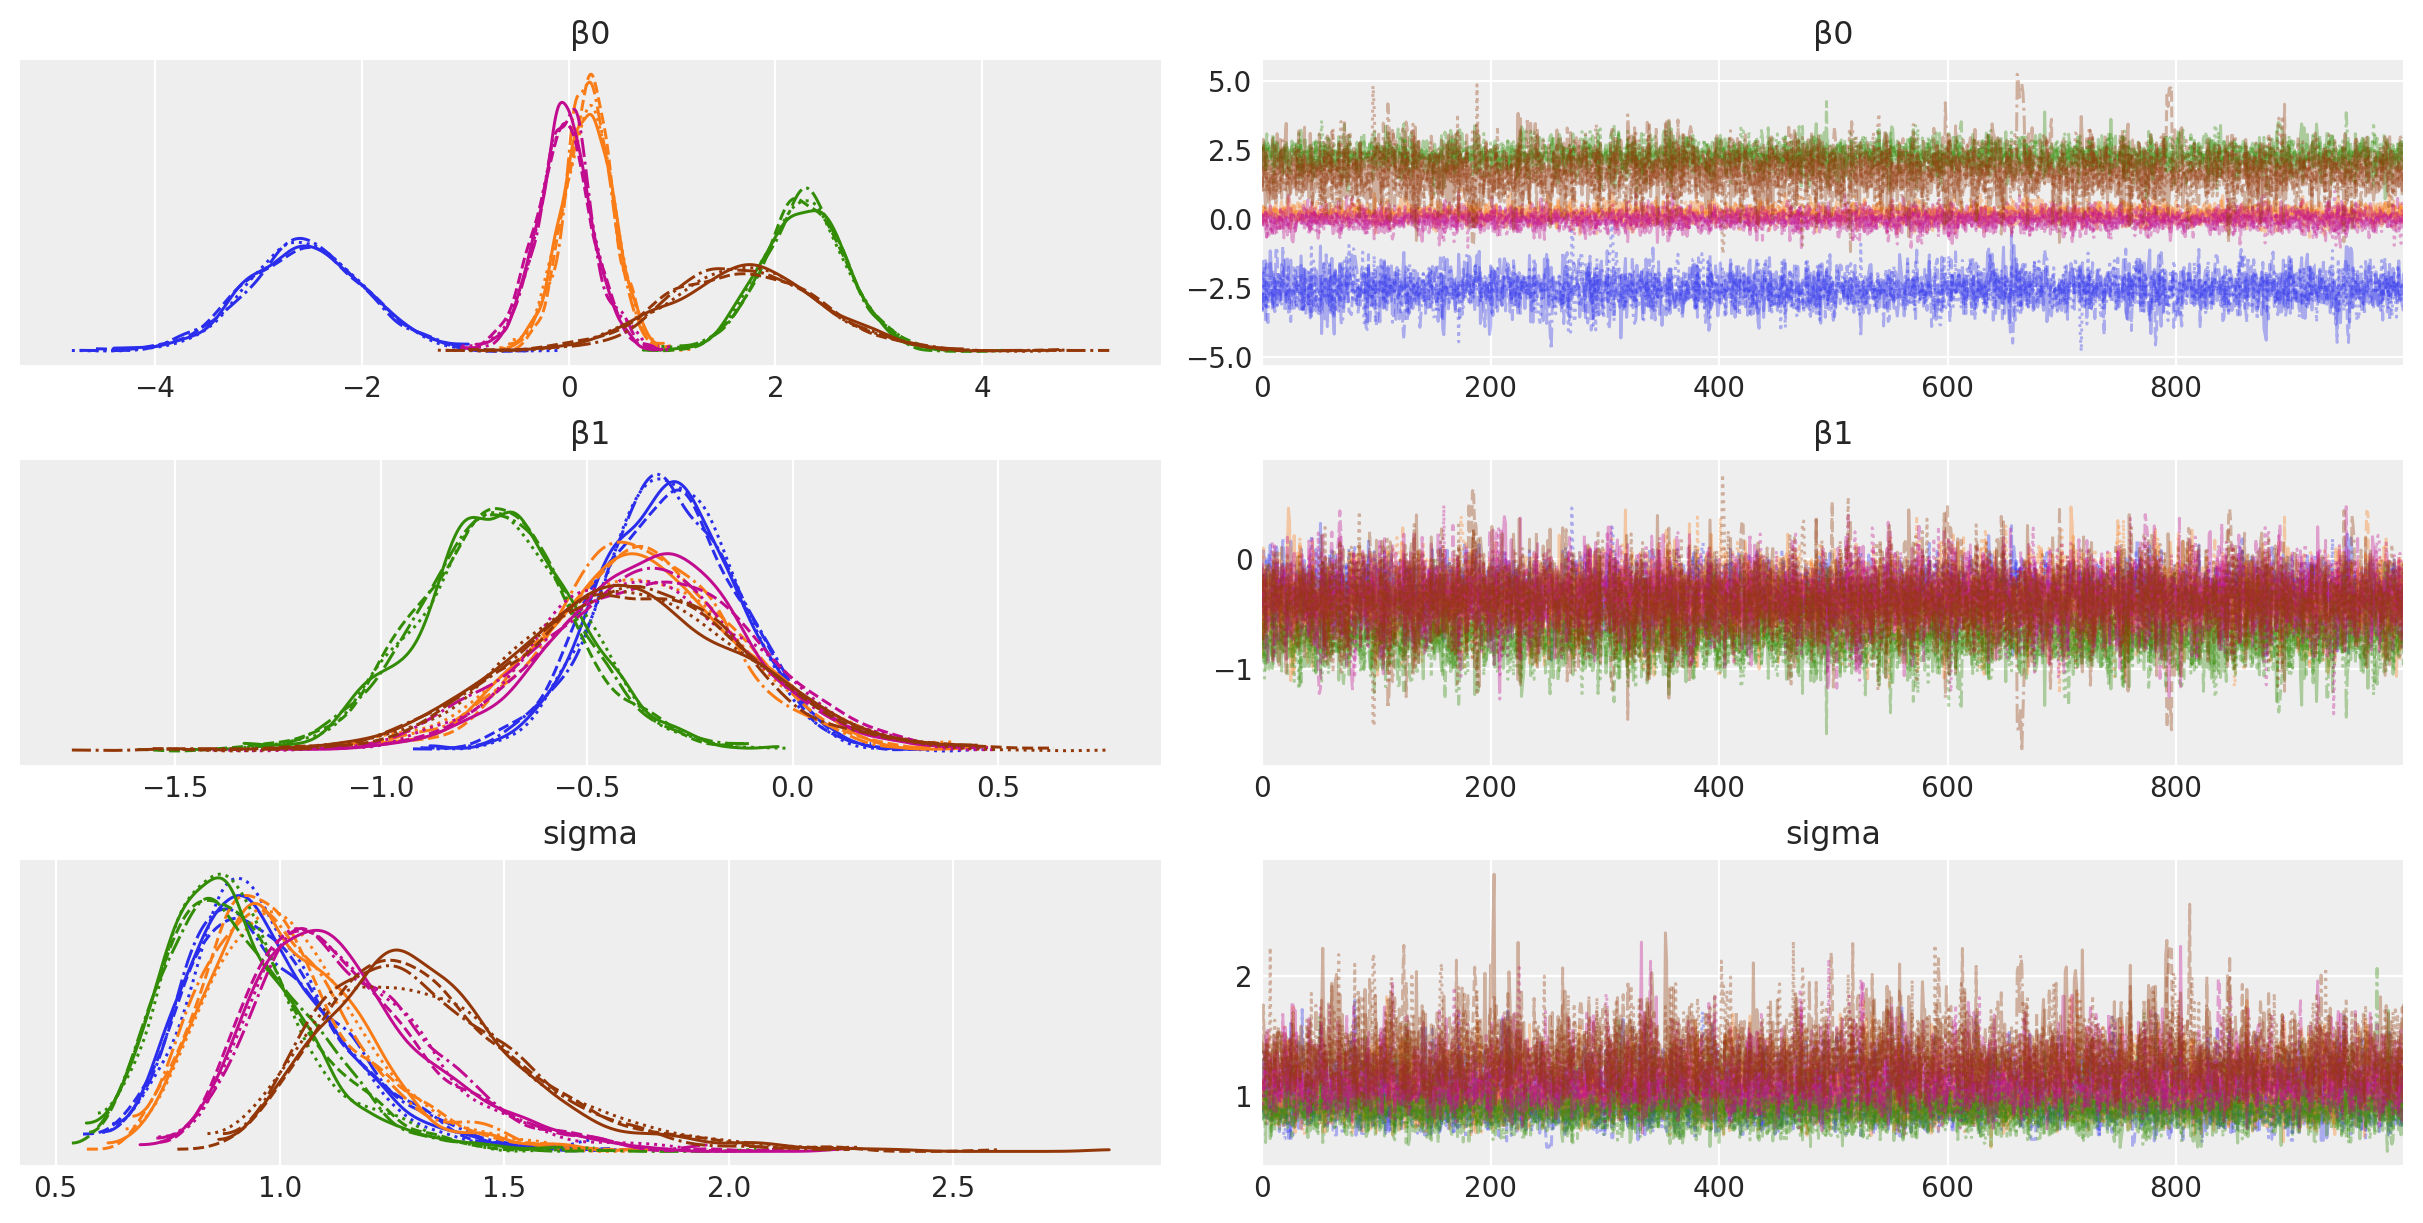

In [15]:
with ind_slope_intercept:
    idata = pm.sample()

az.plot_trace(idata, filter_vars="regex", var_names=["~μ"]);

### Visualisation

In [16]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with ind_slope_intercept:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

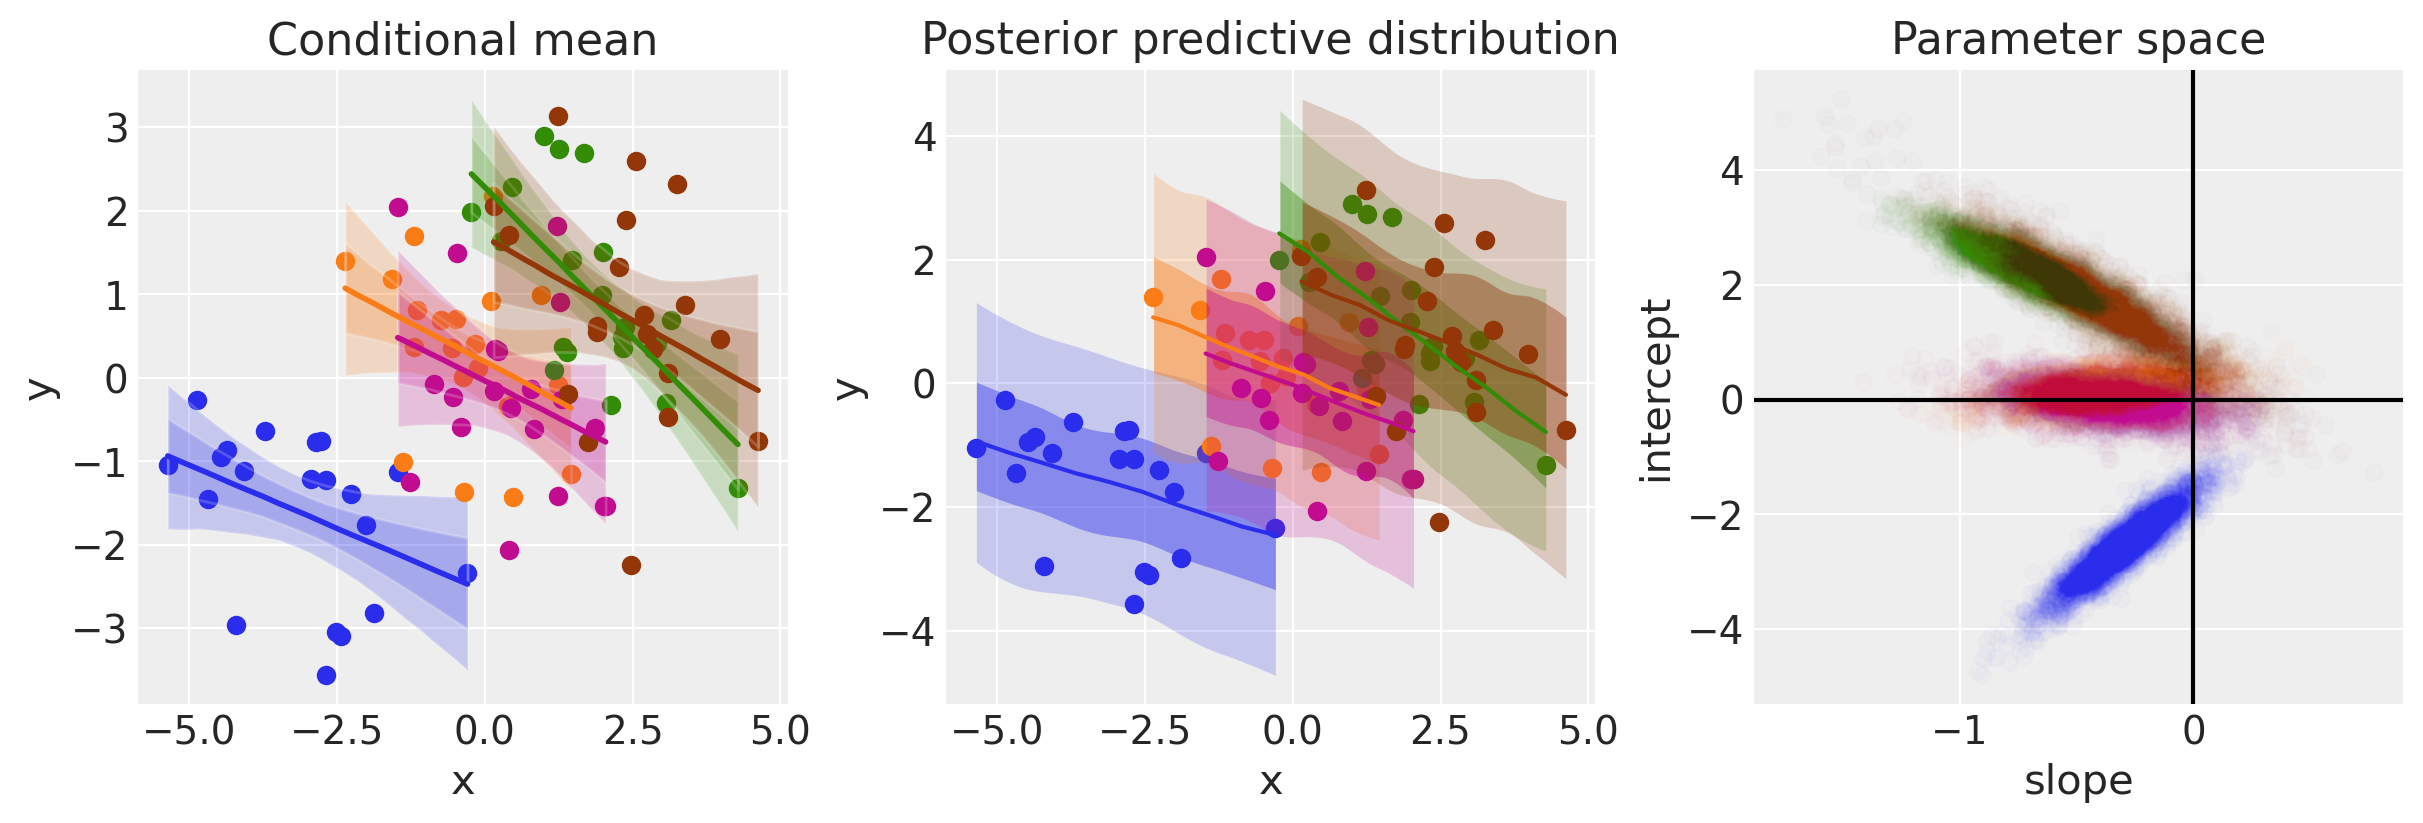

In [17]:
def get_ppy_for_group(group_list, group):
    """Get posterior predictive outcomes for observations from a given group"""
    return idata.posterior_predictive.y.data[:, :, group_list == group]


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = idata.posterior.stack(sample=("chain", "draw"))
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

# posterior prediction ----------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # posterior mean and HDI's
    ax[1].plot(xi[g == i], np.mean(get_ppy_for_group(g, i), axis=(0, 1)), label=groupname)
    az.plot_hdi(
        xi[g == i],
        get_ppy_for_group(g, i),  # pp_y[:, :, g == i],
        hdi_prob=0.6,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.4, "linewidth": 0},
        ax=ax[1],
    )
    az.plot_hdi(
        xi[g == i],
        get_ppy_for_group(g, i),
        hdi_prob=0.95,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax[1],
    )

ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")


# parameter space ---------------------------------------------------
for i, _ in enumerate(group_list):
    ax[2].scatter(
        idata.posterior.β1.stack(sample=("chain", "draw"))[i, :],
        idata.posterior.β0.stack(sample=("chain", "draw"))[i, :],
        color=f"C{i}",
        alpha=0.01,
        rasterized=True,
    )

ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
ax[2].axhline(y=0, c="k")
ax[2].axvline(x=0, c="k");

In contrast to plain regression model (Model 1), when we model on the group level we can see that now the evidence points toward _negative_ relationships between $x$ and $y$.

## Model 3: Hierarchical regression
We can go beyond Model 2 and incorporate even more knowledge about the structure of our data. Rather than treating each group as entirely independent, we can use our knowledge that these groups are drawn from a population-level distribution. These are sometimes called hyper-parameters. 

In one sense this move from Model 2 to Model 3 can be seen as adding parameters, and therefore increasing model complexity. However, in another sense, adding this knowledge about the nested structure of the data actually provides a constraint over parameter space.

Note: This model was producing divergent samples, so a reparameterisation trick is used. See the blog post [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by Thomas Wiecki for more information on this.

In [18]:
with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfCauchy("intercept_sigma", beta=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfCauchy("slope_sigma", beta=2)

    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=2, dims="group")

    # Reparameterise to avoid chain divergences
    # β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
    β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
    β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")

    # Reparameterise to avoid chain divergences
    # β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")
    β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
    β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

Plotting the DAG now makes it clear that the group-level intercept and slope parameters are drawn from a population level distributions. That is, we have hyper-priors for the slopes and intercept parameters. This particular model does not have a hyper-prior for the measurement error - this is just left as one parameter per group, as in the previous model.

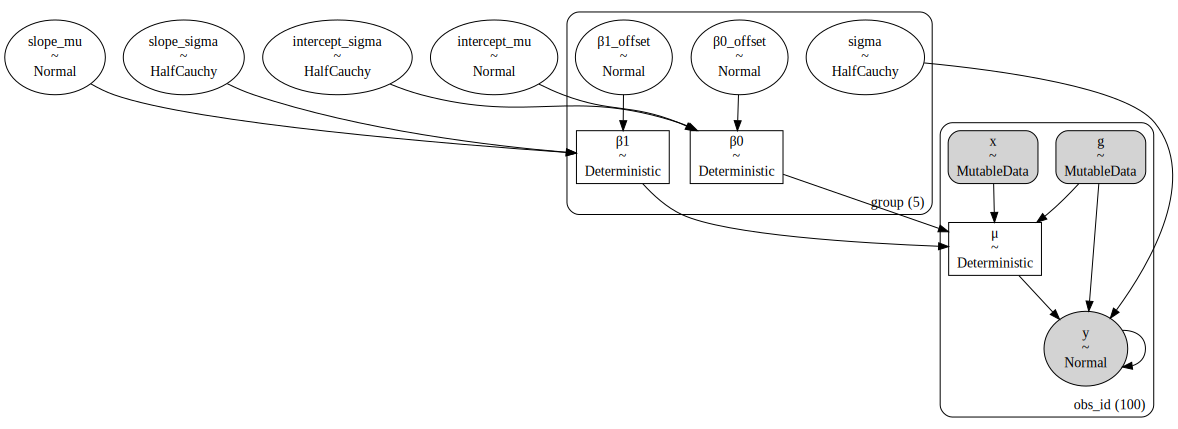

In [19]:
pm.model_to_graphviz(hierarchical)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, slope_mu, slope_sigma, sigma, β0_offset, β1_offset]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 33 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


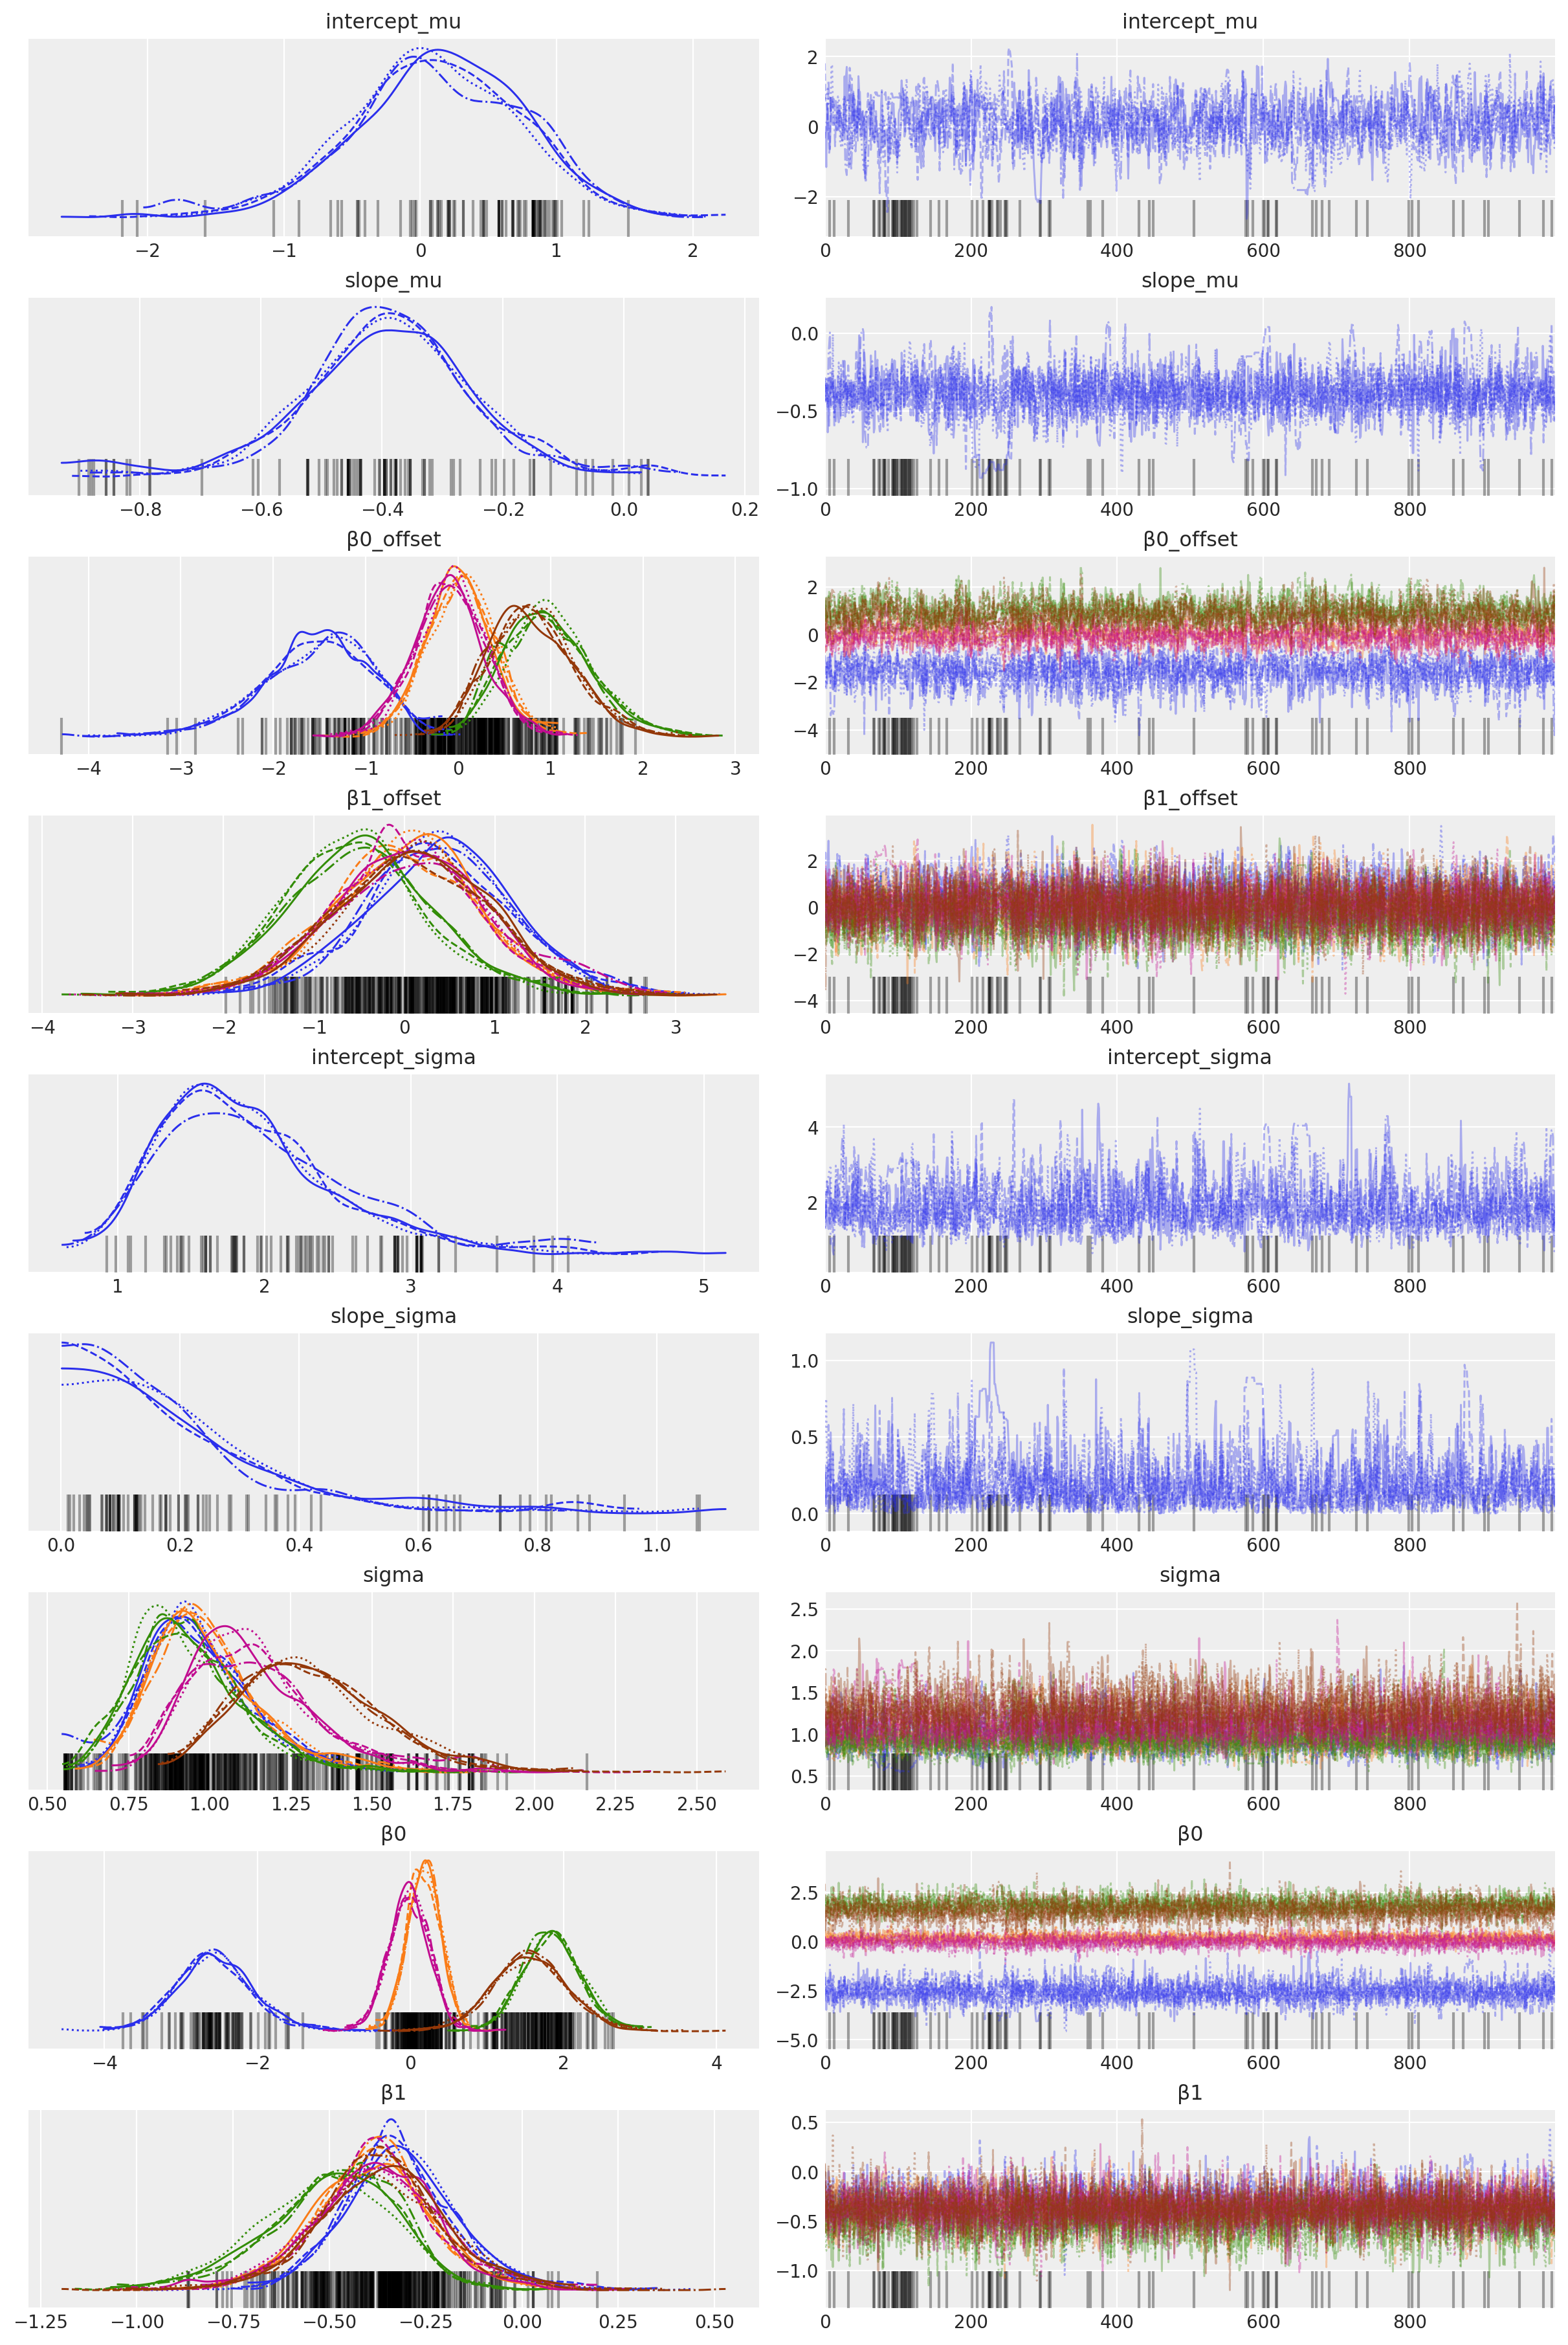

In [20]:
with hierarchical:
    idata = pm.sample(tune=2000)

az.plot_trace(idata, filter_vars="regex", var_names=["~μ"]);

### Visualise

In [21]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with hierarchical:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"], keep_size=True))

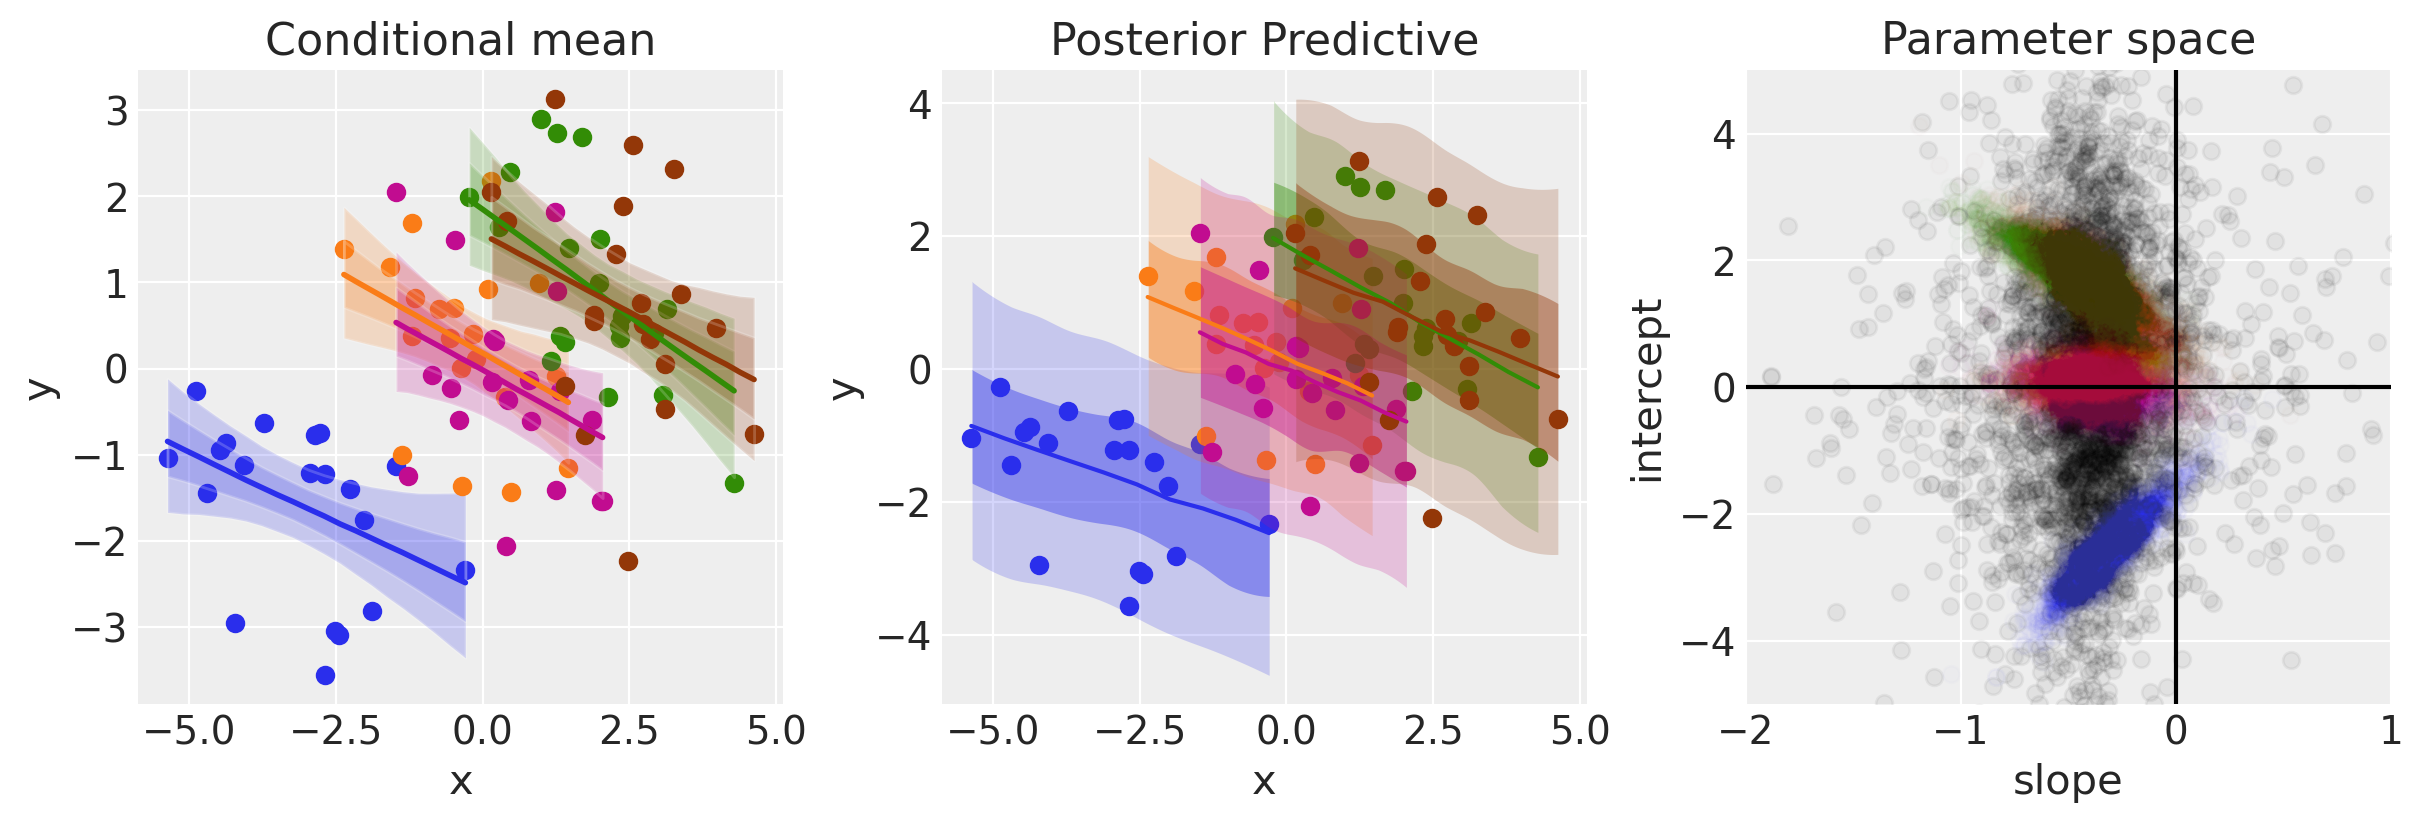

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = idata.posterior.stack(sample=("chain", "draw"))
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

# posterior prediction ----------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # posterior mean and HDI's
    ax[1].plot(xi[g == i], np.mean(get_ppy_for_group(g, i), axis=(0, 1)), label=groupname)
    az.plot_hdi(
        xi[g == i],
        get_ppy_for_group(g, i),
        hdi_prob=0.6,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.4, "linewidth": 0},
        ax=ax[1],
    )
    az.plot_hdi(
        xi[g == i],
        get_ppy_for_group(g, i),
        hdi_prob=0.95,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax[1],
    )

ax[1].set(xlabel="x", ylabel="y", title="Posterior Predictive")

# parameter space ---------------------------------------------------
# plot posterior for population level slope and intercept
slope = rng.normal(
    idata.posterior.slope_mu.stack(sample=("chain", "draw")).values,
    idata.posterior.slope_sigma.stack(sample=("chain", "draw")).values,
)
intercept = rng.normal(
    idata.posterior.intercept_mu.stack(sample=("chain", "draw")).values,
    idata.posterior.intercept_sigma.stack(sample=("chain", "draw")).values,
)
ax[2].scatter(slope, intercept, color="k", alpha=0.05)
# plot posterior for group level slope and intercept
for i, _ in enumerate(group_list):
    ax[2].scatter(
        idata.posterior.β1.stack(sample=("chain", "draw"))[i, :],
        idata.posterior.β0.stack(sample=("chain", "draw"))[i, :],
        color=f"C{i}",
        alpha=0.01,
    )

ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space", xlim=[-2, 1], ylim=[-5, 5])
ax[2].axhline(y=0, c="k")
ax[2].axvline(x=0, c="k");

The panel on the right shows the posterior group level posterior of the slope and intercept parameters in black. This particular visualisation is a little unclear however, so we can just plot the marginal distribution below to see how much belief we have in the slope being less than zero.

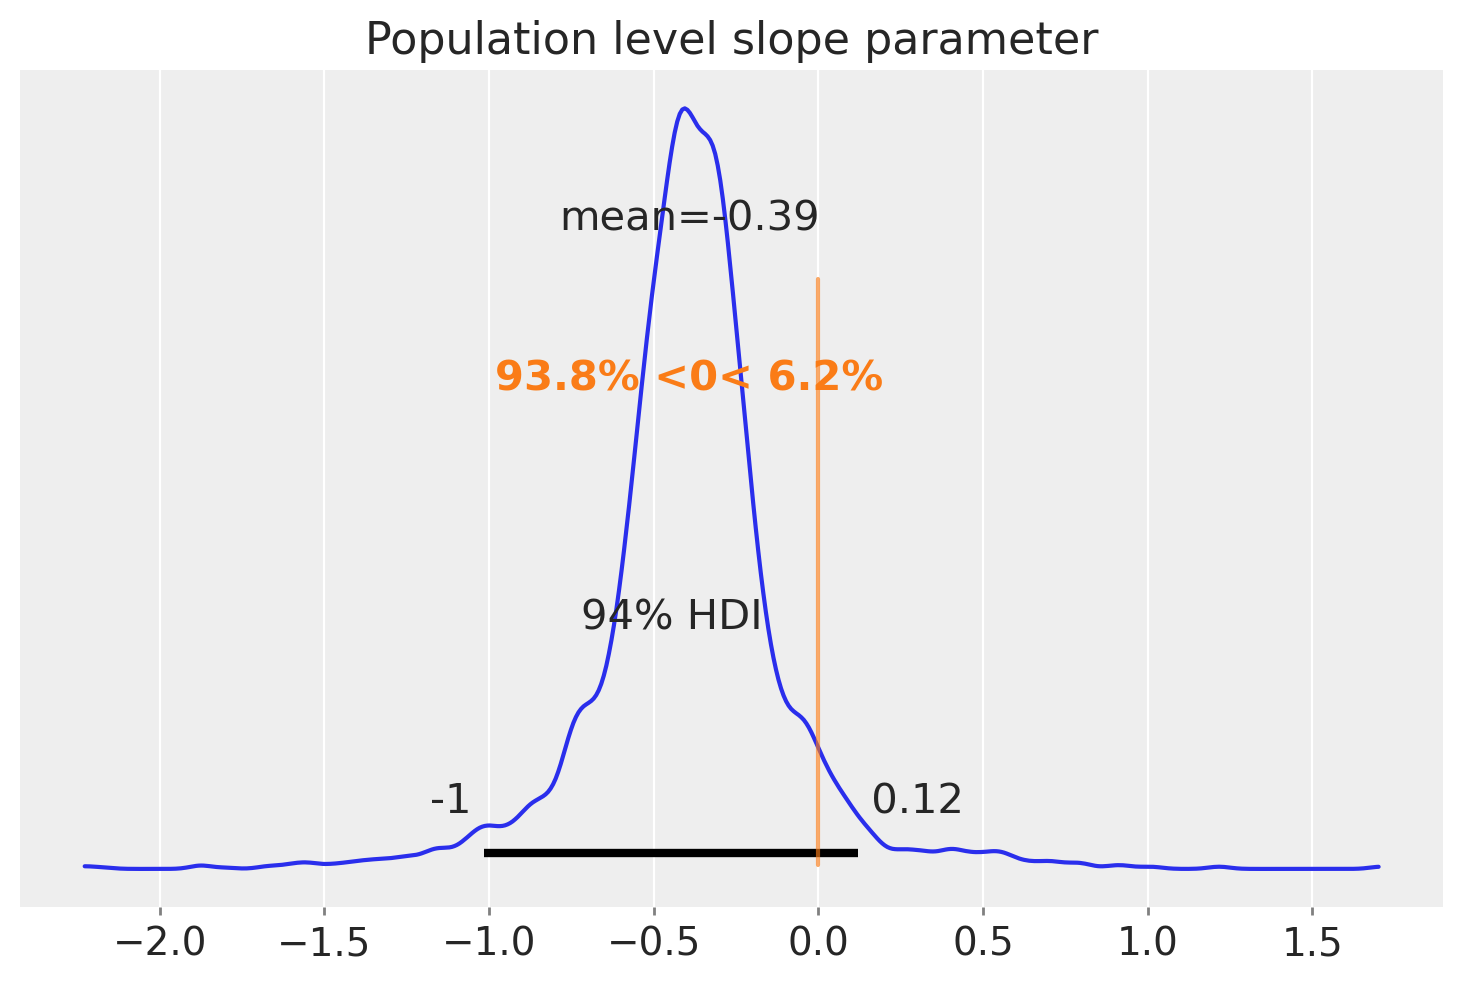

In [23]:
az.plot_posterior(slope, ref_val=0)
plt.title("Population level slope parameter");

## Summary
Using Simpson's paradox, we've walked through 3 different models. The first is a simple linear regression which treats all the data as coming from one group. We saw that this lead us to believe the regression slope was positive.

While that is not necessarily wrong, it is paradoxical when we see that the regression slopes for the data _within_ a group is negative. We saw how to apply separate regressions for data in each group in the second model.

The third and final model added a layer to the hierarchy, which captures our knowledge that each of these groups are sampled from an overall population. This added the ability to make inferences not only about the regression parameters at the group level, but also at the population level. The final plot shows our posterior over this population level slope parameter from which we believe the groups are sampled from.

If you are interested in learning more, there are a number of other [PyMC examples](http://docs.pymc.io/nb_examples/index.html) covering hierarchical modelling and regression topics.

## Authors
* Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2021
* Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in April 2022

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Fri Apr 01 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.31.0

aesara: 2.5.1
aeppl : 0.0.27

pandas    : 1.4.0
xarray    : 0.20.2
arviz     : 0.11.4
pymc      : 4.0.0b6
matplotlib: 3.4.3
numpy     : 1.21.5

Watermark: 2.3.0



:::{include} ../page_footer.md
:::